In [2]:
from quantum_electron import FullModel, PotentialVisualization, package_versions
from quantum_electron.initial_condition import InitialCondition
from quantum_electron.utils import xy2r, r2xy, density_from_positions
import numpy as np
from matplotlib import pyplot as plt
from scipy.constants import elementary_charge as qe, epsilon_0 as eps0, electron_mass as me
from alive_progress import alive_bar
from scipy.signal import find_peaks

package_versions()

quantum_electron 0.2.0
numpy 1.24.2
scipy 1.11.4
matplotlib 3.7.1


In this notebook we study potentials that have a mirror symmetry along one axis. A relevant example is a micro-channel with an electrode at the bottom of the channel. This electrode can generate a parabolic confinement along the channel axis, and electrons are confined by the surrounding ground plane. In an experimental device such channels are usually long, and simulating the full length of the channel is untractable. In addition, trying to cap the ends of the channel will result in electron configurations that don't represent the experiment. Therefore, periodic boundary conditions are implemented in this module.

In the example below, we'll create a sample potential for a micro-channel running along the $x$-direction. We then impose the periodic boundary conditions and look at the resulting electron row formation and mode frequencies.

# Create the potential

In [3]:
# Note that the units of x and y are implicitly assumed as microns
x = np.linspace(-4, 4, 301)
y = np.linspace(-2, 2, 201)

micron = 1e-6

X, Y = np.meshgrid(x, y)
X *= micron
Y *= micron

parabolic_channel = - Y ** 2 / micron ** 2

channel_width = 3e-6
parabolic_channel[np.abs(Y) > channel_width / 2] = - (channel_width/2) ** 2 / micron ** 2

# also add the guard ring
gnd_plane = np.ones(X.shape)
gnd_plane[np.abs(Y) < channel_width / 2] = 0 

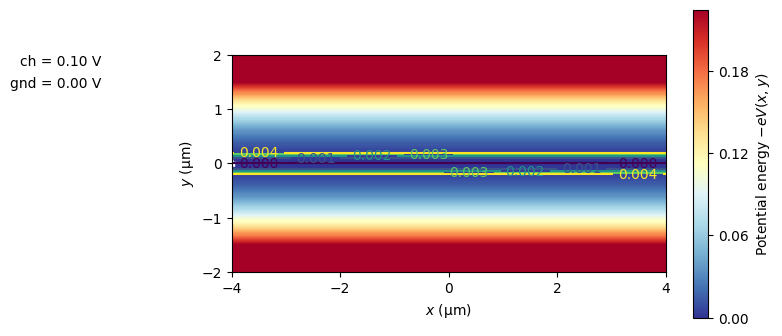

In [4]:
potential_dict = {"ch" : parabolic_channel.T, 
                  "gnd" : gnd_plane.T, 
                  "xlist" : x, 
                  "ylist" : y}

# Let's apply these voltages to the corresponding electrodes in potential_dict
voltages = {"ch" : 0.10, 
            "gnd" : 0}

p = PotentialVisualization(potential_dict, voltages)
p.plot_potential_energy(dxdy=(8, 4))

# Adding electrons

When adding electrons to this potential the periodic boundary conditions ensure that electrons that leave on the right, appear automatically on the left of the simulation domain. Similarly, when `periodic_boundaries = ['y']` electrons that leave towards the top of the simulation domain automatically appear on the bottom. 

In the ideal case of periodic boundaries, electrons would see their own image multiple times and this gives rise to a choice: where do we cut off the coulomb interactions? In this code we choose that each electron only sees every other electron in the simulation box exactly once. If the electron is close to the right border, the interaction with electrons close to the left border is taken with the periodic boundary in mind. That is, we take the minimum distance to each electron, without double counting. 

This choice of approximation is typically acceptable for microchannels which are long enough. 

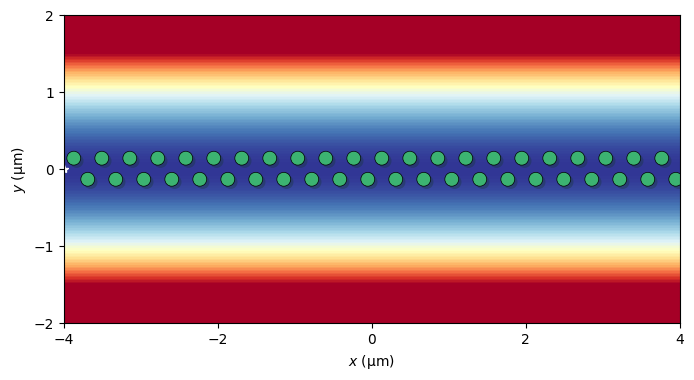

In [11]:
n_electrons = 45

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages, trap_annealing_steps=[10.0]*10, max_x_displacement=0.25e-6, max_y_displacement=0.25e-6)
fm.periodic_boundaries = ['x']
fm.remove_unbound_electrons = False

# Create a rectangular initial condition
ic = InitialCondition(potential_dict, voltages)
initial_condition = ic.make_rectangular(n_electrons=n_electrons, coor=(0, 0), dxdy=(3, .4), n_rows=2)

# Feed this into the model
res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=initial_condition, verbose=False)

fm.plot_potential_energy(ax=ax, dxdy=(8, 4), print_voltages=False, plot_contours=False)
fm.plot_electron_positions(res, ax=ax)
# plt.plot(initial_condition[::2]/micron, initial_condition[1::2]/micron, '.r')

We see the emergence of the electron rows in this case, which are determined by the center pin voltage and the number of electrons in the simulation domain.

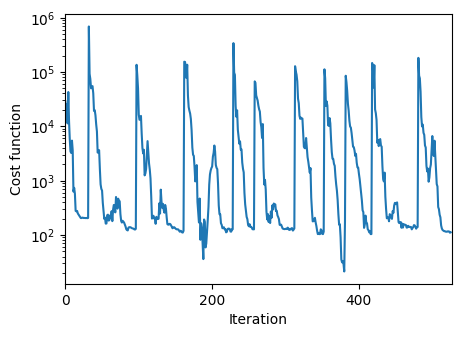

In [7]:
fm.plot_convergence()

# Sweep voltages

The row structure is known to depend on the confinement, which is tunable with the center pin voltage. One way to show this is by sweeping the center pin voltage and binning the electron coordinates along the $y$-axis. Note that for small confinements the electrons tend to escape the channel. We may choose to remove these electrons with the option `remove_unbound_electrons = True`. See the example below

In [53]:
n_electrons = 200
n_ybins = 201

ch_voltages = np.linspace(3.00, 0.05, 101)
electron_histogram = np.zeros((len(ch_voltages), n_ybins-1))

with alive_bar(len(ch_voltages), force_tty=True) as bar:
    for k, Vch in enumerate(ch_voltages):

        voltages = {"ch" : Vch, 
                    "gnd" : 0}

        fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages, trap_annealing_steps=[10.0]*10, max_x_displacement=0.25e-6, max_y_displacement=0.25e-6)
        fm.periodic_boundaries = ['x']
        fm.remove_unbound_electrons = False

        if k == 0:
            # Create a rectangular initial condition
            ic = InitialCondition(potential_dict, voltages)
            initial_condition = ic.make_rectangular(n_electrons=n_electrons, coor=(0, 0), dxdy=(6, .4), n_rows=2)
        else: 
            # Use the results of the previous iterations for the current time step.
            initial_condition = res['x']
        
        # Feed this into the model
        res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=initial_condition, verbose=False)

        final_x, final_y = r2xy(res['x'])
        hist_yfreq, hist_ybins = np.histogram(final_y, bins=0.5 * np.linspace(-channel_width/2, channel_width/2., n_ybins))
        
        electron_histogram[k, :] = hist_yfreq
        bar()
        
ybin_centers = 0.5 * (hist_ybins[1:] + hist_ybins[:-1])


|                                        | ▁▃▅ 0/101 [0%] in 0s (~0s, 0.0/s) 

|████████████████████████████████████████| 101/101 [100%] in 12:14.3 (0.14/s)   


(0.05, 1.0)

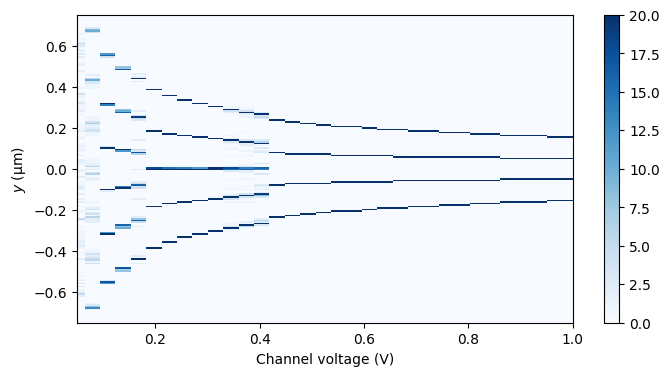

In [54]:
plt.figure(figsize=(8., 4.))
plt.pcolormesh(ch_voltages, ybin_centers / micron, electron_histogram.T, vmax=20, cmap=plt.cm.Blues)
plt.colorbar()

plt.xlabel("Channel voltage (V)")
plt.ylabel(fr"$y$ ({chr(956)}m)")
plt.xlim(0.05, 1.0)

The emergence of electron rows is studied extensively in the literature, and the transition from $n=2$ rows at high voltage to $n = 2, 4, 3, ...$ is known as well in these papers: 
- https://link.springer.com/article/10.1007/s10909-015-1344-4 
- https://journals.aps.org/prb/abstract/10.1103/PhysRevB.69.045324 

Great success!

# An example with fewer rows

For the 1-2 electron transition, we have an analytical solution for the spacing between electrons, which we can compare with the electron histogram. The spacing $d$ between electron rows is given by 

$$ d^2 = \left(\frac{\gamma  e}{4 \pi \epsilon_0 a_1} \right)^\frac{2}{3} - (1/\lambda)^2 $$

where $U = e V_\mathrm{ch} a_1 y ^ 2$ and $\lambda$ is the linear electron density, which can be written as $\lambda = n / \ell_\mathrm{ch}$, and $\ell_\mathrm{ch}$ is the length of the simulated channel.

In [8]:
n_electrons = 50
n_ybins = 201

ch_voltages = np.linspace(1.00, 0.05, 101)
electron_histogram = np.zeros((len(ch_voltages), n_ybins-1))

with alive_bar(len(ch_voltages), force_tty=True) as bar:
    for k, Vch in enumerate(ch_voltages):

        voltages = {"ch" : Vch, 
                    "gnd" : 0}

        fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages, trap_annealing_steps=[10.0]*10, max_x_displacement=0.25e-6, max_y_displacement=0.25e-6)
        fm.periodic_boundaries = ['x']
        fm.remove_unbound_electrons = False

        if k == 0:
            # Create a rectangular initial condition
            ic = InitialCondition(potential_dict, voltages)
            initial_condition = ic.make_rectangular(n_electrons=n_electrons, coor=(0, 0), dxdy=(6, .4), n_rows=2)
        else: 
            # Use the results of the previous iterations for the current time step.
            initial_condition = res['x']
        
        # Feed this into the model
        res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=initial_condition, verbose=False)

        final_x, final_y = r2xy(res['x'])
        hist_yfreq, hist_ybins = np.histogram(final_y, bins=0.5 * np.linspace(-channel_width/2, channel_width/2., n_ybins))
        
        electron_histogram[k, :] = hist_yfreq
        bar()
        
ybin_centers = 0.5 * (hist_ybins[1:] + hist_ybins[:-1])


|████████████████████████████████████████| 101/101 [100%] in 1:14.5 (1.35/s)                                            


/var/folders/x8/8j91v5z97qvb60vlfp731zth0000gn/T/ipykernel_13231/391475614.py:5: RuntimeWarning: invalid value encountered in sqrt
  d = np.sqrt((gamma * qe / (4 * np.pi * eps0 * a1)) ** (2/3) - (1 / lamb) ** 2)


(-0.4, 0.4)

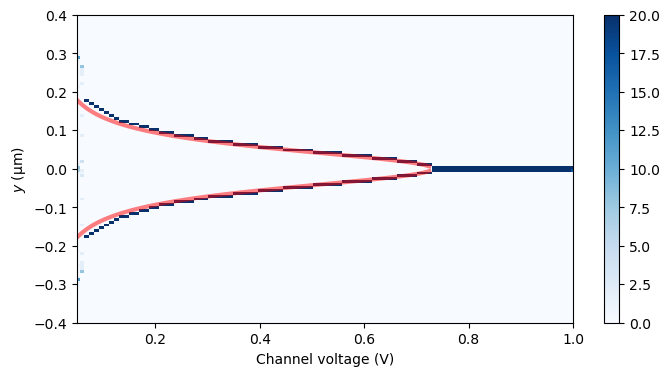

In [9]:
lamb = n_electrons / 8e-6 # box width
gamma = 2.08

a1 = ch_voltages / micron ** 2
d = np.sqrt((gamma * qe / (4 * np.pi * eps0 * a1)) ** (2/3) - (1 / lamb) ** 2)

plt.figure(figsize=(8., 4.))
plt.pcolormesh(ch_voltages, ybin_centers / micron, electron_histogram.T, vmax=20, cmap=plt.cm.Blues)
plt.plot(ch_voltages, d/2 / micron, color='r', alpha=.5, lw=3)
plt.plot(ch_voltages, -d/2 / micron, color='r', alpha=.5, lw=3)
plt.colorbar()

plt.xlabel("Channel voltage (V)")
plt.ylabel(fr"$y$ ({chr(956)}m)")
plt.xlim(0.05, 1.0)
plt.ylim(-.4, .4)

The good agreement in this case gives further confidence in the electrostatics programmed into quantum_electron.

# A phase diagram

In [ ]:
ch_voltages = np.linspace(1.00, 0.05, 101)
n_electrons = np.arange(10, 180.1, 5).astype(int)
n_ybins = 201

electron_histogram = np.zeros((len(n_electrons), len(ch_voltages), n_ybins-1))

with alive_bar(len(ch_voltages) * len(n_electrons), force_tty=True) as bar:
    for idx, n_e in enumerate(n_electrons):
        for k, Vch in enumerate(ch_voltages):

            voltages = {"ch" : Vch, 
                        "gnd" : 0}

            fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages, trap_annealing_steps=[10.0]*10, 
                           max_x_displacement=0.25e-6, max_y_displacement=0.25e-6)
            fm.periodic_boundaries = ['x']
            fm.remove_unbound_electrons = False

            if k == 0:
                # Create a rectangular initial condition
                ic = InitialCondition(potential_dict, voltages)
                initial_condition = ic.make_rectangular(n_electrons=n_electrons, coor=(0, 0), dxdy=(6, .4), n_rows=2)
            else: 
                # Use the results of the previous iterations for the current time step.
                initial_condition = res['x']
            
            # Feed this into the model
            res = fm.get_electron_positions(n_electrons=n_e, electron_initial_positions=initial_condition, 
                                            verbose=False, suppress_warnings=True)

            final_x, final_y = r2xy(res['x'])
            hist_yfreq, hist_ybins = np.histogram(final_y, bins=0.5 * np.linspace(-channel_width/2, channel_width/2., n_ybins))
            
            electron_histogram[idx, k, :] = hist_yfreq
            bar()
        
ybin_centers = 0.5 * (hist_ybins[1:] + hist_ybins[:-1])

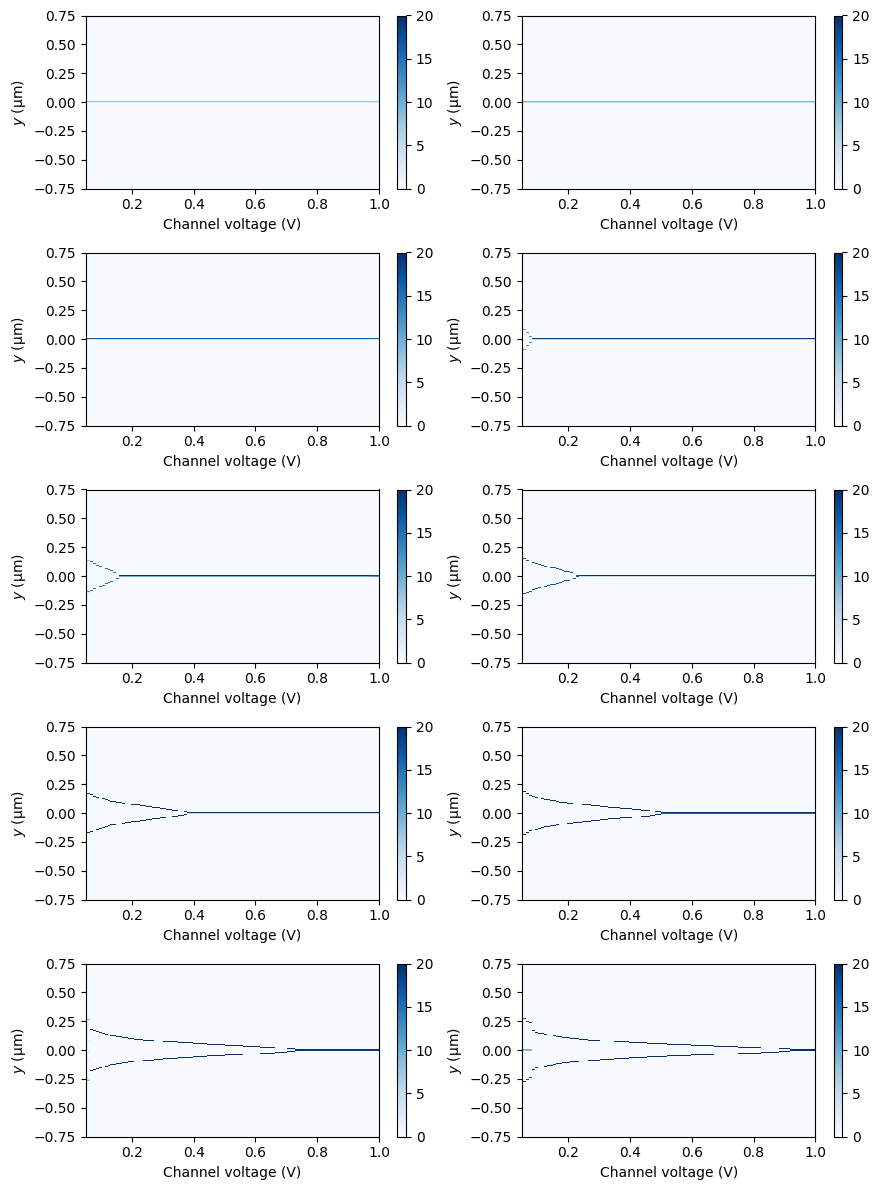

In [57]:
fig, ax = plt.subplots(5, 2, figsize=(9., 3*4.))
ax = ax.flatten()

for idx, n_e in enumerate(n_electrons[:10]):
    pcm = ax[idx].pcolormesh(ch_voltages, ybin_centers / micron, electron_histogram[idx].T, vmax=20, cmap=plt.cm.Blues)
    plt.colorbar(pcm)

    ax[idx].set_xlabel("Channel voltage (V)")
    ax[idx].set_ylabel(fr"$y$ ({chr(956)}m)")
    ax[idx].set_xlim(0.05, 1.0)

fig.tight_layout()

We can now construct a phase diagram and compare at least the 1 to 2 row transition with the theoretical expected value.

This value can be derived from the same expression derived above for the distance between two electron rows: 

$$ d^2 = \left(\frac{\gamma  e}{4 \pi \epsilon_0 a_1} \right)^\frac{2}{3} - (1/\lambda)^2 $$

When the expression under the square root reaches zero, the ensemble transitions into a single row. Therefore we can write 

$$ 1 / \lambda = \left(\frac{\gamma  e}{4 \pi \epsilon_0 a_1} \right)^\frac{1}{3} $$

and thus 

$$ n / w = \left(\frac{4 \pi \epsilon_0 a_1}{\gamma  e}\right)^\frac{1}{3} $$
where $w$ is the simulation box width.

/var/folders/dj/frggnr5511ncvfw6_l9jnbnw0000gn/T/ipykernel_26566/3476764646.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu_r', np.max(n_rows) - np.min(n_rows) + 1)


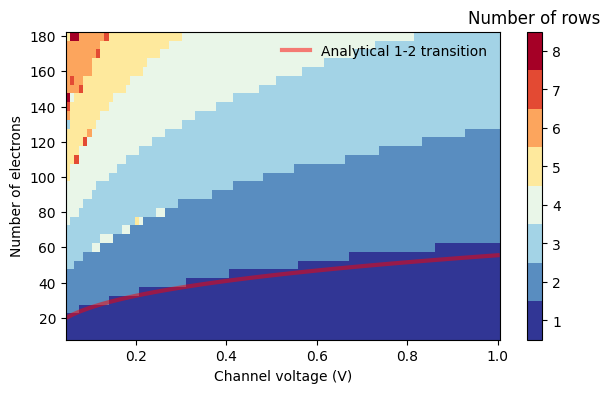

In [73]:
n_rows = np.zeros(electron_histogram.shape[:2])

for n_idx, n_e in enumerate(n_electrons):
    for v_idx in range(len(ch_voltages)):
        peaks, _ = find_peaks(electron_histogram[n_idx, v_idx], distance=10, height=3)
        n_rows[n_idx, v_idx] = len(peaks)

cmap = plt.cm.get_cmap('RdYlBu_r', np.max(n_rows) - np.min(n_rows) + 1)

plt.figure(figsize=(7, 4.))
plt.pcolormesh(ch_voltages, n_electrons, n_rows, cmap=cmap, vmin=np.min(n_rows) - 0.5, vmax=np.max(n_rows) + 0.5)
cbar = plt.colorbar()
cbar.ax.set_title("Number of rows")
plt.xlabel("Channel voltage (V)")
plt.ylabel("Number of electrons")

gamma = 2.08
a1 = ch_voltages / micron ** 2
n_12 = (4 * np.pi * eps0 * a1 / (gamma * qe)) ** (1/3) * 8e-6

plt.plot(ch_voltages, n_12, color='r', alpha=.5, lw=3, label="Analytical 1-2 transition")
plt.legend(loc=0, frameon=False)

There is an interesting feature that occurs on the transition from 2 to 3 rows, where the preferred lowest energy state is a four row configuration.

# Eigenmodes

The eigenmodes of electrons in a microchannel and their interaction with a microwave resonator has been studied in this work: 
- https://journals.aps.org/prx/abstract/10.1103/PhysRevX.6.011031

Here we look to reproduce these eigenmodes. Let us first try to get a sense of the frequency scale in this problem, which is set by the trap curvature:

In [8]:
print("Trap curvature for electrons is", 1 / (2 * np.pi * 1e9) * np.sqrt(2 * qe * voltages['ch'] / micron ** 2 / me), "GHz")

Trap curvature for electrons is 29.850102621705076 GHz


/Users/gkoolstra/Documents/Code/quantum_electron/quantum_electron/eom_solver.py:278: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(EVals) / (2 * np.pi), EVecs


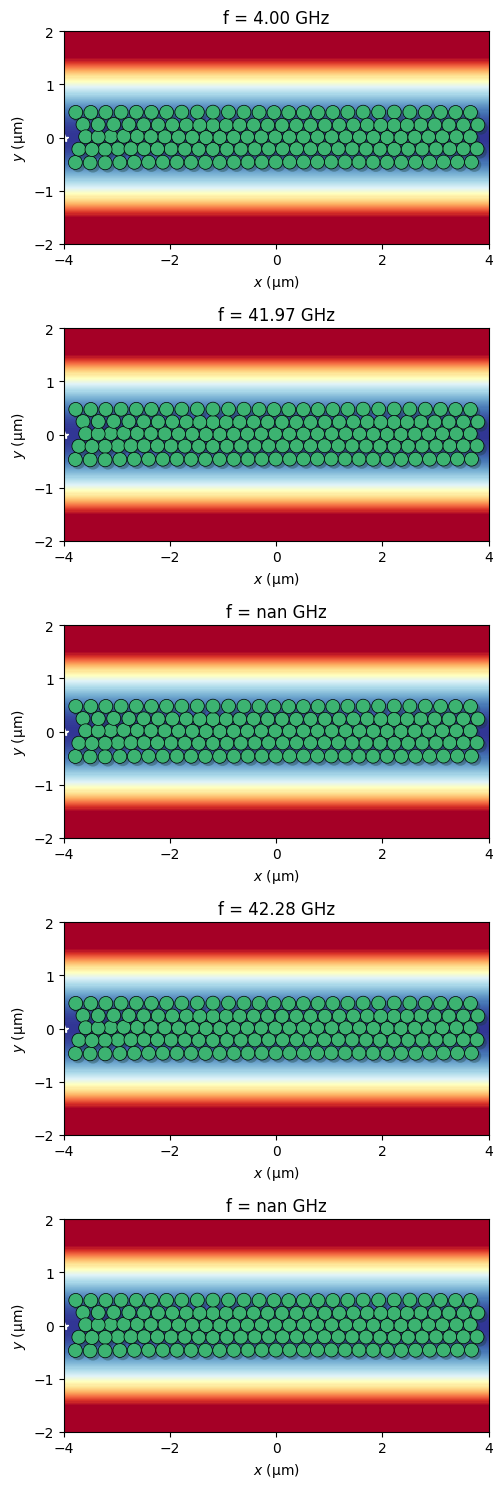

In [9]:
n_electrons = 150
n_plots = 5

resonator_dict = {"f0" : 4e9, 
                  "Z0" : 50}

fig, ax = plt.subplots(n_plots, 1, figsize=(6, 3*n_plots))

fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages, trap_annealing_steps=[10.0]*10, max_x_displacement=0.25e-6, max_y_displacement=0.25e-6)
fm.periodic_boundaries = ['x']
fm.remove_unbound_electrons = True
fm.set_rf_interpolator(rf_electrode_labels=['ch'])

# Create a rectangular initial condition
ic = InitialCondition(potential_dict, voltages)
initial_condition = ic.make_rectangular(n_electrons=n_electrons, coor=(0, 0), dxdy=(6, .4), n_rows=2)

# Feed this into the model
res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=initial_condition, verbose=False)

for n in range(n_plots):
    fm.plot_potential_energy(ax=ax[n], dxdy=(8, 4), print_voltages=False, plot_contours=False)

    # Solve the equations of motion
    K, M = fm.setup_eom(res['x'], resonator_dict=resonator_dict)
    efreqs, evecs = fm.solve_eom(K, M)

    ax[n].set_title(f"f = {efreqs[n]/1e9:.2f} GHz")
    
fig.tight_layout()
anim = fm.animate_eigenvectors(fig, ax, evecs.T, res['x'])

In [19]:
fm.show_animation(anim)

In [20]:
xi, yi = r2xy(res['x'])
n_s = density_from_positions(xi, yi)
print(f"Density = {n_s:.2e} m^-2")

Density = 1.36e+13 m^-2
